# 🎧 Emotion Classification from Audio using RAVDESS

## 📁 1 IMPORT THE LIBRARIES

In [103]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np


import os
import sys
import random

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio, display

## 📁 2. Load & Explore the Dataset

In [4]:
data_path = "/kaggle/input/ravdess-emotional-speech-audio"
print(os.listdir(data_path))

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [5]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [6]:
emotions = []
datas = []

for actor_folder in os.listdir(data_path):
    actor_path = os.path.join(data_path,actor_folder)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                full_path = os.path.join(actor_path,file)
                emotion_code = file.split("-")[2]
                emotion = emotion_map.get(emotion_code)
                if emotion:  # if valid code
                    datas.append(full_path)
                    emotions.append(emotion)

df = pd.DataFrame({
    "file_path":datas,
    "emotion":emotions
})

df.head()

,file_path,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/A...,surprised
1,/kaggle/input/ravdess-emotional-speech-audio/A...,neutral
2,/kaggle/input/ravdess-emotional-speech-audio/A...,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/A...,disgust
4,/kaggle/input/ravdess-emotional-speech-audio/A...,neutral


In [7]:
print(f"df shape is {df.shape}")

df shape is (1440, 2)


emotion
surprised    192
disgust      192
fearful      192
sad          192
happy        192
calm         192
angry        192
neutral       96
Name: count, dtype: int64


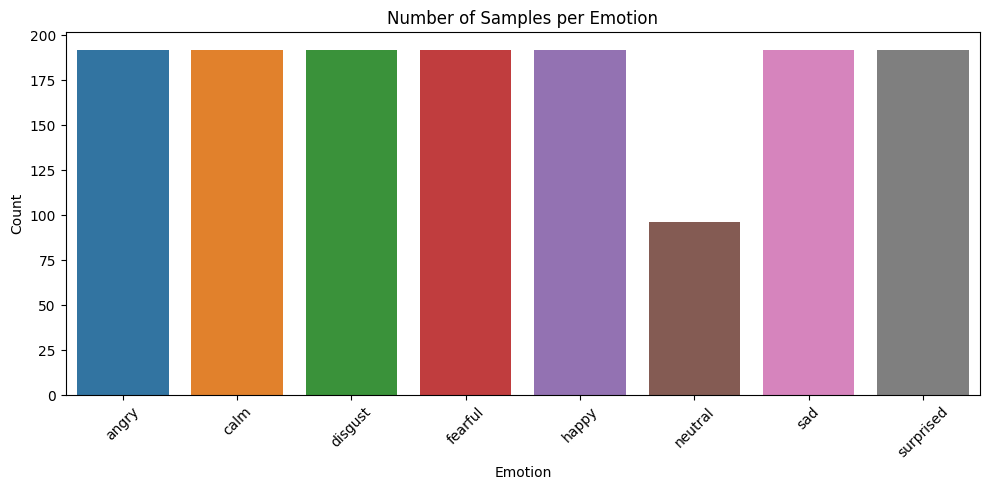

In [8]:
print(df['emotion'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="emotion", order=sorted(df["emotion"].unique()))
plt.title("Number of Samples per Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# let's see sample example data 

y , sr = librosa.load(df['file_path'][0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape y: (77988,)
sr: 22050


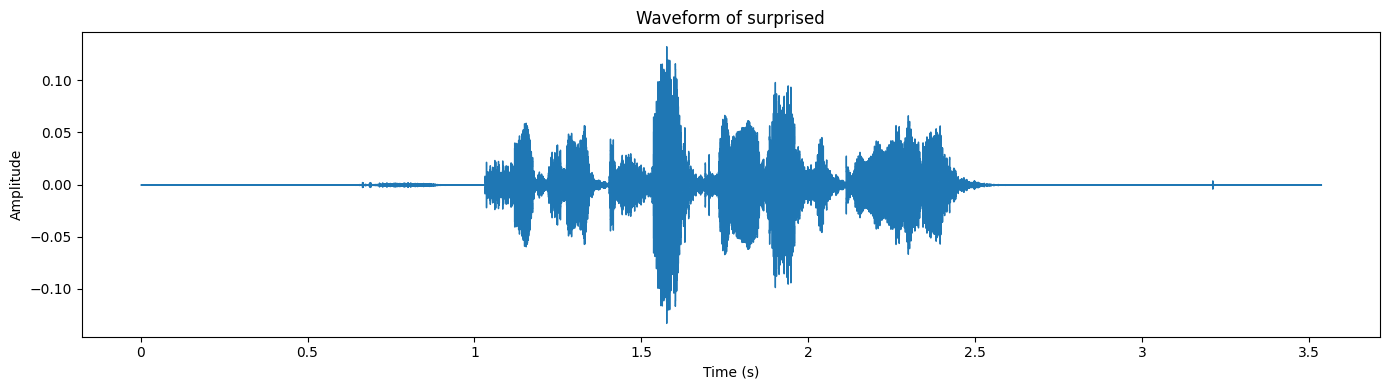

In [10]:
# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {df['emotion'].iloc[0]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

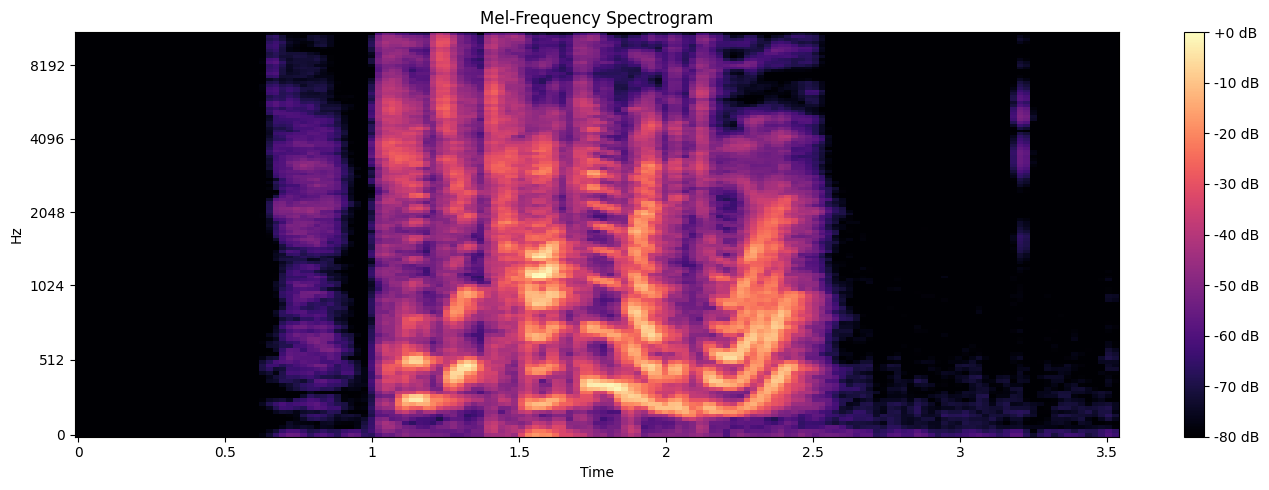

In [11]:
# Plot spectrogram (log scale Mel spectrogram)
plt.figure(figsize=(14, 5))
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Frequency Spectrogram")
plt.tight_layout()
plt.show()

## 🧠 3. Feature Extraction
- Extract MFCCs
- Chroma
- Spectral Contrast
- Zero Crossing Rate
- RMSE

In [12]:
def extract_features(y, sr):
    
    try:
        
        stft = np.abs(librosa.stft(y))
        
        #  Extrainting MFCC 
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        
        # Extracting CHroma
        chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)
        
        # Extrainting Spectral Contrast 
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
        contrast_mean = np.mean(contrast.T, axis=0)
        
        # Extrainting Zero Crossing Rate 
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        
    
        rmse = librosa.feature.rms(y=y)
        rmse_mean = np.mean(rmse)


        result = np.hstack([
            mfcc_mean,
            chroma_mean,
            contrast_mean,
            zcr_mean,
            rmse_mean
        ])
        
        return result
    
    except Exception as e:
        print(f"Error extracting features: {e}")
        return np.zeros(61)  

## 🧪 4. Data Augmentation

To improve the model's generalization and robustness, we applied **data augmentation** to the audio files. This technique helps simulate different recording conditions and speaker variations.

- Noise injection
- Pitch shifting
- Combined with feature extraction

### Understandig data aumentation with examples

In [104]:
# loading example data
file_path = df['file_path'][0]
audio, sr = librosa.load(file_path, duration=3)

# Augmentations
noise = audio + 0.005 * np.random.normal(0, 1, len(audio))
pitch = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)

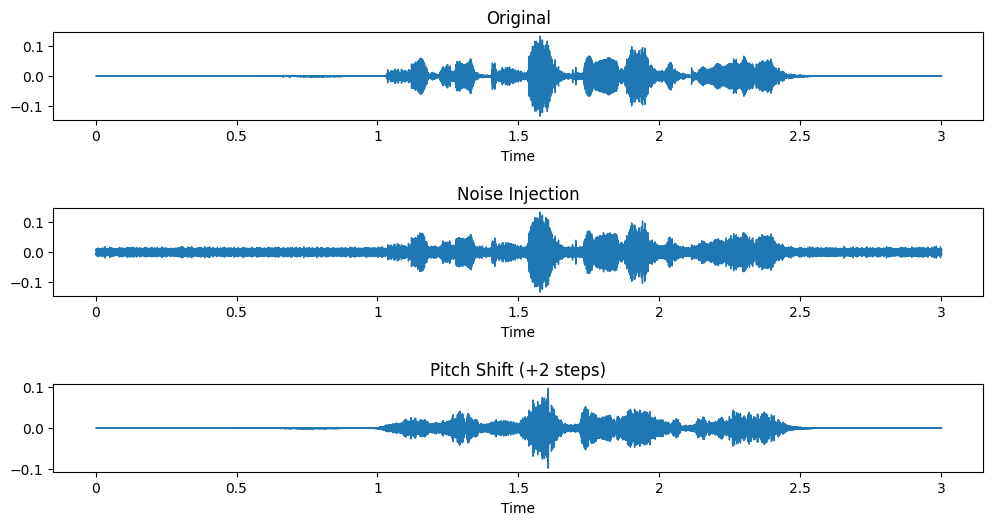

In [108]:
# Plot waveforms
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title("Original")


plt.subplot(4, 1, 2)
librosa.display.waveshow(noise, sr=sr)
plt.title("Noise Injection")


plt.subplot(4, 1, 3)
librosa.display.waveshow(pitch, sr=sr)
plt.title("Pitch Shift (+2 steps)")

plt.subplots_adjust(hspace=1)
plt.show()

In [109]:
# Audio playback
print("▶️ Original Audio:")
display(Audio(audio, rate=sr))

print("▶️ Noise Injection:")
display(Audio(noise, rate=sr))

print("▶️ Pitch Shift:")
display(Audio(pitch, rate=sr))

▶️ Original Audio:


▶️ Noise Injection:


▶️ Pitch Shift:


### 🔁 Building the Full Augmented Dataset

In [13]:
def augment_and_extract(data, sr, frame_length=2048, hop_length=512):
    
    def add_noise(x):
        noise_level = random.uniform(0.003, 0.01)
        return x + noise_level * np.random.normal(0, 1, len(x))

    def shift_pitch(x):
        steps = random.choice([-2, -1, 1, 2])
        return librosa.effects.pitch_shift(x, sr=sr, n_steps=steps)

    def time_stretch(x):
        rate = random.uniform(0.9, 1.1)
        return librosa.effects.time_stretch(x, rate=rate)

    # Augmentation pipeline
    augmentations = [
        data,                                # original
        add_noise(data),                     # noise
        shift_pitch(data),                   # pitch
        shift_pitch(add_noise(data)),        # pitch + noise
    ]
   
    # Feature extraction
    return np.vstack([
        extract_features(aug, sr)
        for aug in augmentations
    ])


## 🧹 5. Clean & Organize Dataset
- Create DataFrame of features and labels
- One-hot encode labels
- Split into train/val/test sets

In [14]:
X = []
y = []

for idx,row in tqdm(df.iterrows()):
        
    path = row['file_path']
    emotion = row['emotion']

    try:
        data , sr = librosa.load(path)

        features = augment_and_extract(data, sr)

        for _ in range(features.shape[0]):
            X.append(features[_])
            y.append(emotion)

    except Exception as e:
        print(f"Error processing {path}: {e}")
        continue

1440it [07:01,  3.41it/s]


In [15]:
features_df = pd.DataFrame(X)
features_df['label'] = y


print("Shape:", features_df.shape)
features_df.head()

Shape: (5760, 62)


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,label
0,-578.057007,38.450909,-14.525623,10.058562,-7.268931,-7.338440,-3.074346,-5.954073,-3.085561,-3.633329,...,16.130166,15.361307,16.852131,16.178719,16.759089,17.092911,40.366412,0.235687,0.006981,surprised
1,-258.080093,7.033596,-0.620733,-1.341709,-2.287461,-2.957920,-2.117041,-2.420193,-3.005791,-1.507002,...,10.878362,12.688778,14.595542,13.631637,13.745237,13.853621,13.586896,0.406250,0.012279,surprised
2,-591.635010,41.158497,-18.804867,11.492136,-9.690894,-6.008449,-6.856624,-4.222411,-7.159162,-0.968346,...,16.243643,15.568235,17.313828,15.972407,17.286234,17.753721,52.856631,0.166590,0.004771,surprised
3,-309.995560,34.740094,-24.900877,24.261838,-26.901185,21.457394,-25.339267,21.399873,-25.515833,18.304114,...,11.992085,12.695859,14.903210,13.845977,14.596211,14.250491,69.651372,0.349644,0.008418,surprised
4,-650.710876,54.477310,-9.090126,8.411754,-4.387534,-3.765707,-5.362751,-8.610381,-3.971552,-0.895974,...,17.291765,15.724447,16.684837,15.131320,16.950688,17.009339,41.892130,0.270194,0.003616,neutral


In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = features_df.drop(columns=['label']).values

le = LabelEncoder()

y_encoded = le.fit_transform(features_df['label'])  
y_onehot = to_categorical(y_encoded)

print("Shape of the X",X.shape)
print("Shape of one-hot encoded labels:", y_onehot.shape)


Shape of one-hot encoded labels: (5760, 8)


In [110]:
def split_data(X,y,test_size=0.1,val_size=0.1):

    X_train , X_test , y_train ,y_test = train_test_split(X,y,test_size = test_size,random_state=42)

    X_train, X_val , y_train , y_val = train_test_split(X_train,y_train , test_size=val_size )

    return {
        "X_train":X_train,
        "X_valid":X_val,
        "X_test":X_test,
        "y_train":y_train,
        "y_val":y_val,
        "y_test":y_test
    }

data = split_data(X,y_onehot)

## 🤖 6. Classical Machine Learning Models (RandomForestClassifier)

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Decode one-hot labels 
if len(data['y_train'].shape) > 1:
    y_train_rf = np.argmax(data['y_train'], axis=1)
    y_val_rf = np.argmax(data['y_val'], axis=1)
    y_test_rf = np.argmax(data['y_test'], axis=1)
else:
    y_train_rf, y_val_rf, y_test_rf = y_train, y_val, y_test


In [113]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(data['X_train'], y_train_rf)

y_val_pred = rf_model.predict(data['X_valid'])
y_test_pred = rf_model.predict(data['X_test'])

✅ Validation Accuracy: 0.5164
✅ Test Accuracy: 0.5191

📋 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        87
           1       0.52      0.76      0.61        83
           2       0.44      0.48      0.46        82
           3       0.54      0.49      0.51        72
           4       0.45      0.41      0.43        73
           5       0.42      0.21      0.28        38
           6       0.40      0.31      0.35        68
           7       0.53      0.64      0.58        73

    accuracy                           0.52       576
   macro avg       0.51      0.49      0.49       576
weighted avg       0.52      0.52      0.51       576



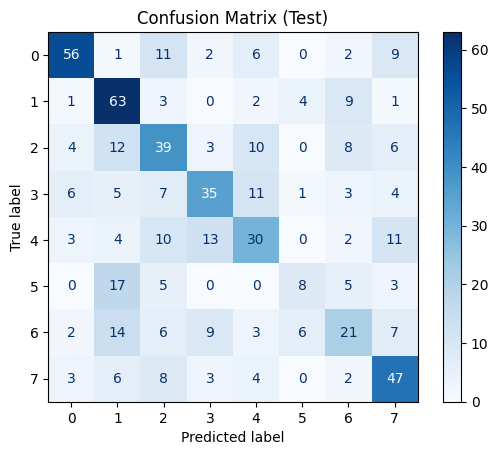

In [114]:
val_acc = accuracy_score(y_val_rf, y_val_pred)
test_acc = accuracy_score(y_test_rf, y_test_pred)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")



print("\n📋 Classification Report (Test):")
print(classification_report(y_test_rf, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_rf, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.show()

## 🧱 7. Deep Learning Model (MLP / CNN)
- Build and train a TensorFlow model
- Use BatchNorm, Dropout, Regularization
- Plot training & validation curves

In [76]:
#---------------------- Training --------------------------------------------- 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout ,BatchNormalization
from tensorflow.keras import regularizers


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU is available:", gpus[0])
else:
    print("❌ GPU not available, using CPU.")



# Define model
model = Sequential([
    Dense(256, activation='relu', input_shape=(data['X_train'].shape[1],),kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(data['y_train'].shape[1], activation='softmax')  # output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

✅ GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 256)                 │          15,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,176 (559.28 KB)

 Trainable params: 141,512 (552.78 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [77]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Watch validation loss
    factor=0.5,             # Reduce the learning rate by half
    patience=10,            # Wait 10 epochs before reducing
    min_lr=1e-6,            # Never go below this learning rate
    verbose=1               # Print updates
)
history = model.fit(
    data['X_train'], data['y_train'],
    validation_data=(data['X_valid'], data['y_val']),
    epochs=250,
    batch_size=32,
    callbacks=[
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        lr_schedule
        
    ],
    verbose=1  # Shows training progress
)


Epoch 1/250
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.1579 - loss: 3.2905 - val_accuracy: 0.1985 - val_loss: 3.1746 - learning_rate: 0.0010
Epoch 2/250
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2191 - loss: 2.7031 - val_accuracy: 0.2775 - val_loss: 2.3711 - learning_rate: 0.0010
Epoch 3/250
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2499 - loss: 2.5574 - val_accuracy: 0.3121 - val_loss: 2.3148 - learning_rate: 0.0010
Epoch 4/250
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2712 - loss: 2.4654 - val_accuracy: 0.3372 - val_loss: 2.2611 - learning_rate: 0.0010
Epoch 5/250
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2893 - loss: 2.3712 - val_accuracy: 0.3276 - val_loss: 2.2932 - learning_rate: 0.0010
Epoch 6/250
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3044 - loss: 2.3144 - val_accuracy: 0.3719 - val_loss: 2.1699 - learning_rate: 0.0010
Epoch 7/250
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3337 - loss: 

## ✅ 8. Model Evaluation
- Accuracy
- Confusion Matrix
- ROC Curve

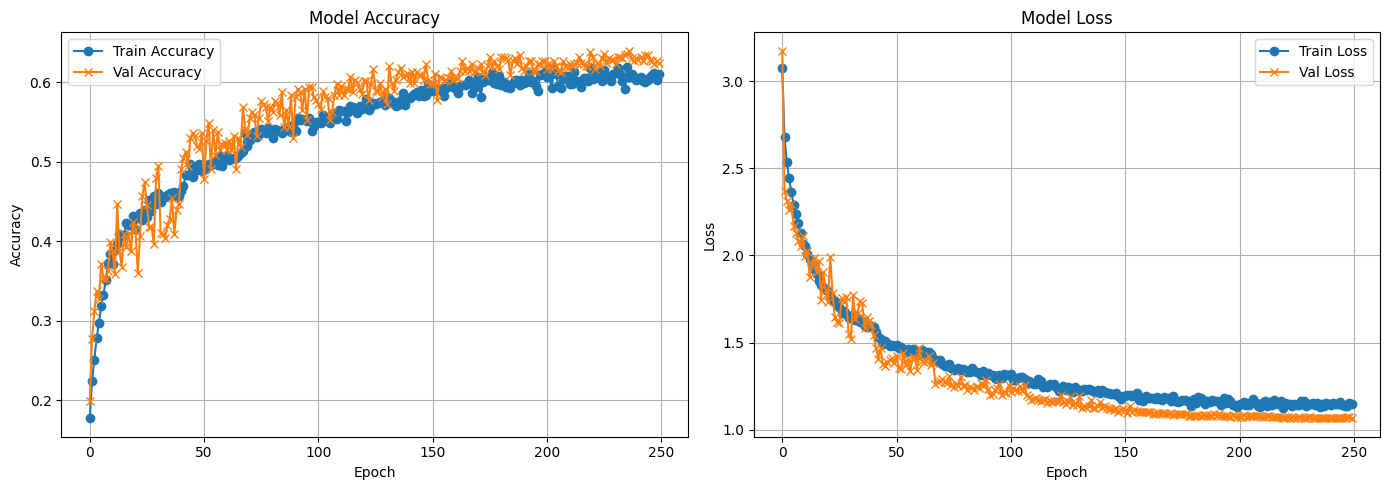

In [78]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [79]:
# Predict probabilities and classes
y_pred_probs = model.predict(data['X_test'])
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(data['y_test'], axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [80]:
test_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.62


In [81]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80        87
           1       0.58      0.76      0.66        83
           2       0.53      0.51      0.52        82
           3       0.72      0.65      0.69        72
           4       0.53      0.63      0.58        73
           5       0.41      0.34      0.37        38
           6       0.57      0.46      0.51        68
           7       0.70      0.66      0.68        73

    accuracy                           0.62       576
   macro avg       0.61      0.60      0.60       576
weighted avg       0.62      0.62      0.62       576



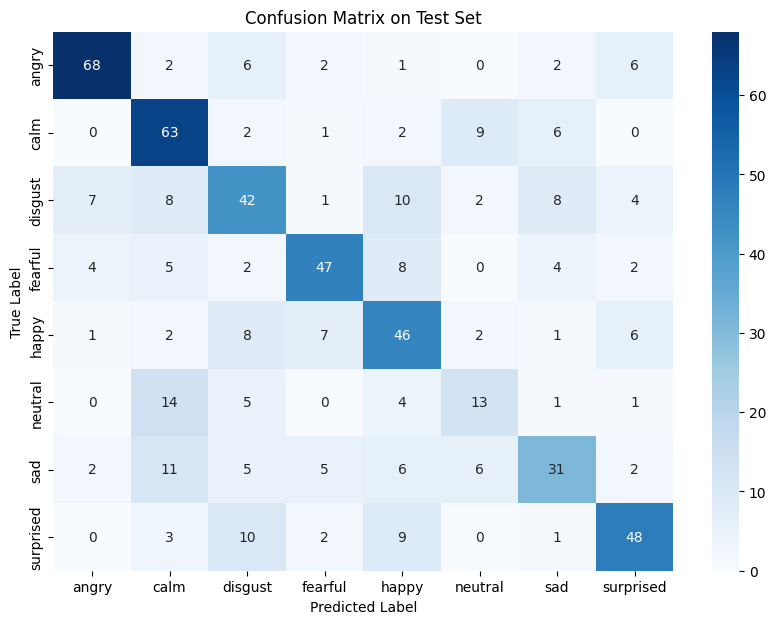

In [84]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()

## 💾 9. Save Final Model & Dataset

In [86]:
# save the model 
model.save("final_model.h5")

In [92]:
import joblib

y_labels = np.argmax(y_onehot, axis=1)

final_df = pd.DataFrame(X)
final_df['label'] = y_labels

# Save to CSV
final_df.to_csv("final_dataset.csv", index=False)


In [118]:
import joblib


joblib.dump(le, "le.pkl")

['le.pkl']

In [121]:
model.save("final_model.keras")

In [122]:
tf.__version__

'2.17.1'